In [63]:
%%html
<style type='text/css'>
.CodeMirror{
    font-family: Inconsolata;
    font-size: 13px;
}

div.output_area pre {
    font-family: Inconsolata;
    font-size: 11px;
}

div.text_cell_render {
    font-family: Inconsolata;
    font-size: 15px;
}
</style>

In [64]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# https://stackoverflow.com/questions/16183462/saving-images-in-python-at-a-very-high-quality

from tqdm.notebook import tqdm, tqdm_notebook
tqdm.pandas()

from datetime import datetime, timedelta
from math import ceil

In [65]:
path_dataset = r"/data/data2/041/datasets/mimic-iii-clinical-database-1.4"
list_csvgz = [f for f in os.listdir(path_dataset) if f[-6:]=="csv.gz"]
list_csvgz

['DRGCODES.csv.gz',
 'LABEVENTS.csv.gz',
 'PATIENTS.csv.gz',
 'D_ITEMS.csv.gz',
 'DIAGNOSES_ICD.csv.gz',
 'CAREGIVERS.csv.gz',
 'SERVICES.csv.gz',
 'CPTEVENTS.csv.gz',
 'PRESCRIPTIONS_PREPROCESSED.csv.gz',
 'OUTPUTEVENTS.csv.gz',
 'D_LABITEMS.csv.gz',
 'D_ICD_DIAGNOSES.csv.gz',
 'CALLOUT.csv.gz',
 'ADMISSIONS.csv.gz',
 'D_CPT.csv.gz',
 'INPUTEVENTS_MV.csv.gz',
 'final_data_of_previous_works.csv.gz',
 'D_LABITEMS_NEW.csv.gz',
 'PROCEDUREEVENTS_MV.csv.gz',
 'ADMISSIONS_NEW.csv.gz',
 'PRESCRIPTIONS.csv.gz',
 'NOTEEVENTS.csv.gz',
 'DATETIMEEVENTS.csv.gz',
 'MICROBIOLOGYEVENTS.csv.gz',
 'ICUSTAYS.csv.gz',
 'DRUGS_NDC_FEAT.csv.gz',
 'D_ICD_PROCEDURES.csv.gz',
 'CHARTEVENTS.csv.gz',
 'TRANSFERS.csv.gz',
 'PROCEDURES_ICD.csv.gz',
 'LABEVENTS_PREPROCESSED.csv.gz',
 'INPUTEVENTS_CV.csv.gz']

---

# ADMISSIONS

In [66]:
df_admissions = pd.read_csv(os.path.join(path_dataset, "ADMISSIONS.csv.gz"))

# Convert columns to datetime
df_admissions["ADMITTIME"] = pd.to_datetime(df_admissions["ADMITTIME"], format="%Y-%m-%d %H:%M:%S")
df_admissions["DISCHTIME"] = pd.to_datetime(df_admissions["DISCHTIME"], format="%Y-%m-%d %H:%M:%S")

df_admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ROW_ID                58976 non-null  int64         
 1   SUBJECT_ID            58976 non-null  int64         
 2   HADM_ID               58976 non-null  int64         
 3   ADMITTIME             58976 non-null  datetime64[ns]
 4   DISCHTIME             58976 non-null  datetime64[ns]
 5   DEATHTIME             5854 non-null   object        
 6   ADMISSION_TYPE        58976 non-null  object        
 7   ADMISSION_LOCATION    58976 non-null  object        
 8   DISCHARGE_LOCATION    58976 non-null  object        
 9   INSURANCE             58976 non-null  object        
 10  LANGUAGE              33644 non-null  object        
 11  RELIGION              58518 non-null  object        
 12  MARITAL_STATUS        48848 non-null  object        
 13  ETHNICITY       

In [67]:
df_admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


## intersection

In [68]:
df_labevents     = pd.read_csv(os.path.join(path_dataset, "LABEVENTS_PREPROCESSED.csv.gz"), index_col=0)
df_prescriptions = pd.read_csv(os.path.join(path_dataset, "PRESCRIPTIONS_PREPROCESSED.csv.gz"), index_col=0)

def get_list_total_hadmid(*list_df_single_edges_type: list):
    r"""
    Get the interset of hadmid from df(s) which record(s) the edge connection.
    """
    if len(list_df_single_edges_type) <= 1:
        return list(list_df_single_edges_type[0].HADM_ID.unique())
    else:
        list_set_hadmid_single_edges_type = [set(list(df_single_edges_type.HADM_ID.unique()))
                                             for df_single_edges_type in list_df_single_edges_type]
        return list(set.intersection(*list_set_hadmid_single_edges_type))

list_total_hadmid = get_list_total_hadmid(df_labevents, df_prescriptions)
mask = df_admissions.HADM_ID.isin(list_total_hadmid)
df_admissions = df_admissions.loc[mask]
df_admissions

/data/data2/041/envs/LERS2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3269: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,V-TACH,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,2131-03-30 19:44:00,2131-03-30 22:41:00,TRAUMA,0,1
58972,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,2151-03-05 17:23:00,2151-03-05 21:06:00,SAH,1,1
58973,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,RENAL CANCER/SDA,0,1
58974,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,CATHOLIC,MARRIED,WHITE,2128-11-10 23:48:00,2128-11-11 03:16:00,S/P FALL,0,0


## Admission stay

In [69]:
df_admissions["STAYTIME"] = (df_admissions["DISCHTIME"] - df_admissions["ADMITTIME"]) / timedelta(days=1)
df_admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,STAYTIME
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,5.496528
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1,6.768056
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,2.856944
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,3.534028
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,V-TACH,0,1,6.988889


In [70]:
df_admissions["STAYTIME"].mean(), df_admissions["STAYTIME"].std()

(10.698379222709404, 12.615131859967097)

In [71]:
df_admissions[df_admissions.DEATHTIME.notnull()].STAYTIME.mean(), df_admissions[df_admissions.DEATHTIME.notnull()].STAYTIME.std()

(10.717074003731842, 14.15419768231098)

In [72]:
df_admissions[df_admissions.DEATHTIME.isnull()].STAYTIME.mean(), df_admissions[df_admissions.DEATHTIME.isnull()].STAYTIME.std()

(10.696277325730954, 12.430354943796024)

In [73]:
df_admissions[df_admissions.DEATHTIME.notnull()].shape[0]

5002

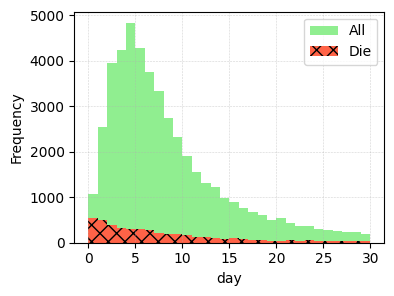

In [74]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(df_admissions.STAYTIME.values, bins=30, range=(0, 30), histtype='stepfilled', color='lightgreen')
ax.hist(df_admissions[df_admissions.DEATHTIME.notnull()].STAYTIME.values, bins=30, range=(0, 30), histtype='stepfilled', color='tomato', hatch='xx')
ax.set_ylabel("Frequency")
ax.set_xlabel("day")
ax.grid(True, linestyle=':', linewidth=.41)
ax.legend(["All", "Die"])
# fig.suptitle("Histogram of length of admission stay")

## Func for getting specified hadm id's admission start time and end time

In [75]:
def get_start_end_by_hadm_id(df_admissions, query_hadm_id: int):
    df_this_hadm = df_admissions[df_admissions.HADM_ID == query_hadm_id]
    assert len(df_this_hadm) > 0
    return df_this_hadm.ADMITTIME.values[0], df_this_hadm.DISCHTIME.values[0]

get_start_end_by_hadm_id(df_admissions, query_hadm_id=152223)

(numpy.datetime64('2153-09-03T07:15:00.000000000'),
 numpy.datetime64('2153-09-08T19:10:00.000000000'))

## Decision happen time distribution

In [87]:
gb_hadmid_labevents = df_labevents.groupby(['HADM_ID'])
gb_hadmid_prescriptions = df_prescriptions.groupby(['HADM_ID'])

def get_labevents_proportion(hadm_id: int, before_proportion: float) -> int:
    assert 0 < before_proportion and before_proportion <= 1
    
    df = gb_hadmid_labevents.get_group(hadm_id)
    # df = df_labevents[df_labevents.HADM_ID == hadm_id]
    
    # ceil due to our process way of timestep
    staytime = df_admissions[df_admissions.HADM_ID == hadm_id].STAYTIME.values[0]
    duration = ceil(staytime)
    time_cut = ceil(duration * before_proportion)
    
    return len(df[df.TIMESTEP <= time_cut]) / len(df)

def get_prescriptions_proportion(hadm_id: int, before_proportion: float) -> int:
    assert 0 < before_proportion and before_proportion <= 1
    
    df = gb_hadmid_prescriptions.get_group(hadm_id)
    # df = df_labevents[df_labevents.HADM_ID == hadm_id]
    
    # ceil due to our process way of timestep
    staytime = df_admissions[df_admissions.HADM_ID == hadm_id].STAYTIME.values[0]
    duration = ceil(staytime)
    time_cut = ceil(duration * before_proportion)
    
    return len(df[df.TIMESTEP <= time_cut]) / len(df)

# df_admissions.head().HADM_ID.progress_apply(get_labevents_proportion, args=(0.5,))
df_admissions.head().HADM_ID.progress_apply(get_prescriptions_proportion, args=(0.5,))

  0%|          | 0/5 [00:00<?, ?it/s]

1    0.883562
2    0.697368
3    1.000000
4    1.000000
5    0.709924
Name: HADM_ID, dtype: float64

In [77]:
df_admissions['proportion_labevents_before1/4'] = df_admissions.HADM_ID.progress_apply(get_labevents_proportion, args=(1/4,))
df_admissions['proportion_labevents_before2/4'] = df_admissions.HADM_ID.progress_apply(get_labevents_proportion, args=(2/4,))
df_admissions['proportion_labevents_before3/4'] = df_admissions.HADM_ID.progress_apply(get_labevents_proportion, args=(3/4,))
df_admissions['proportion_labevents_before7/8'] = df_admissions.HADM_ID.progress_apply(get_labevents_proportion, args=(7/8,))
df_admissions

  0%|          | 0/49491 [00:00<?, ?it/s]

  0%|          | 0/49491 [00:00<?, ?it/s]

  0%|          | 0/49491 [00:00<?, ?it/s]

  0%|          | 0/49491 [00:00<?, ?it/s]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,STAYTIME,proportion_labevents_before1/4,proportion_labevents_before2/4,proportion_labevents_before3/4,proportion_labevents_before7/8
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,5.496528,0.911111,0.966667,1.00000,1.0
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,NaN,NaN,BRAIN MASS,0,1,6.768056,0.308511,0.627660,0.87766,1.0
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1,2.856944,0.587629,0.793814,1.00000,1.0
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,3.534028,0.673913,0.840580,1.00000,1.0
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,...,NaN,NaN,V-TACH,0,1,6.988889,0.237500,0.593750,0.88125,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,2131-03-30 19:44:00,2131-03-30 22:41:00,TRAUMA,0,1,2.742361,0.652174,0.826087,1.00000,1.0
58972,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,...,2151-03-05 17:23:00,2151-03-05 21:06:00,SAH,1,1,0.548611,1.000000,1.000000,1.00000,1.0
58973,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,...,NaN,NaN,RENAL CANCER/SDA,0,1,8.203472,0.993548,0.993548,1.00000,1.0
58974,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,...,2128-11-10 23:48:00,2128-11-11 03:16:00,S/P FALL,0,0,41.445833,0.737209,0.818605,0.87907,1.0


In [85]:
labevent_proportions = [
    df_admissions['proportion_labevents_before1/4'].mean(),
    df_admissions['proportion_labevents_before2/4'].mean(),
    df_admissions['proportion_labevents_before3/4'].mean(),
    df_admissions['proportion_labevents_before7/8'].mean()
]

labevent_proportions

[0.580868424402069, 0.7708306526444954, 0.9354763550722971, 0.9849731064355511]

In [86]:
labevent_proportions_std = [
    df_admissions['proportion_labevents_before1/4'].std(),
    df_admissions['proportion_labevents_before2/4'].std(),
    df_admissions['proportion_labevents_before3/4'].std(),
    df_admissions['proportion_labevents_before7/8'].std()
]

labevent_proportions_std

[0.20262155121859918,
 0.14846536307149003,
 0.07563247815243636,
 0.031013043520476236]

In [88]:
df_admissions['proportion_prescriptions_before1/4'] = df_admissions.HADM_ID.progress_apply(get_prescriptions_proportion, args=(1/4,))
df_admissions['proportion_prescriptions_before2/4'] = df_admissions.HADM_ID.progress_apply(get_prescriptions_proportion, args=(2/4,))
df_admissions['proportion_prescriptions_before3/4'] = df_admissions.HADM_ID.progress_apply(get_prescriptions_proportion, args=(3/4,))
df_admissions['proportion_prescriptions_before7/8'] = df_admissions.HADM_ID.progress_apply(get_prescriptions_proportion, args=(7/8,))
df_admissions

  0%|          | 0/49491 [00:00<?, ?it/s]

  0%|          | 0/49491 [00:00<?, ?it/s]

  0%|          | 0/49491 [00:00<?, ?it/s]

  0%|          | 0/49491 [00:00<?, ?it/s]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HAS_CHARTEVENTS_DATA,STAYTIME,proportion_labevents_before1/4,proportion_labevents_before2/4,proportion_labevents_before3/4,proportion_labevents_before7/8,proportion_prescriptions_before1/4,proportion_prescriptions_before2/4,proportion_prescriptions_before3/4,proportion_prescriptions_before7/8
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1,5.496528,0.911111,0.966667,1.00000,1.0,0.773973,0.883562,1.000000,1.000000
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,1,6.768056,0.308511,0.627660,0.87766,1.0,0.335526,0.697368,1.000000,1.000000
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,...,1,2.856944,0.587629,0.793814,1.00000,1.0,0.704545,1.000000,1.000000,1.000000
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,1,3.534028,0.673913,0.840580,1.00000,1.0,0.655738,1.000000,1.000000,1.000000
5,26,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,...,1,6.988889,0.237500,0.593750,0.88125,1.0,0.381679,0.709924,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,...,1,2.742361,0.652174,0.826087,1.00000,1.0,0.375000,1.000000,1.000000,1.000000
58972,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,...,1,0.548611,1.000000,1.000000,1.00000,1.0,1.000000,1.000000,1.000000,1.000000
58973,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,...,1,8.203472,0.993548,0.993548,1.00000,1.0,0.456140,0.692982,1.000000,1.000000
58974,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,...,0,41.445833,0.737209,0.818605,0.87907,1.0,0.337586,0.567223,0.816487,0.930324


In [89]:
prescription_proportions = [
    df_admissions['proportion_prescriptions_before1/4'].mean(),
    df_admissions['proportion_prescriptions_before2/4'].mean(),
    df_admissions['proportion_prescriptions_before3/4'].mean(),
    df_admissions['proportion_prescriptions_before7/8'].mean()
]

prescription_proportions

[0.5060021406847149, 0.7407332014933588, 0.9395063567249301, 0.98882991407989]

In [90]:
prescription_proportions_std = [
    df_admissions['proportion_prescriptions_before1/4'].std(),
    df_admissions['proportion_prescriptions_before2/4'].std(),
    df_admissions['proportion_prescriptions_before3/4'].std(),
    df_admissions['proportion_prescriptions_before7/8'].std()
]

prescription_proportions_std

[0.2353635900621431,
 0.18441722063122049,
 0.08952057760523605,
 0.03671058976007954]

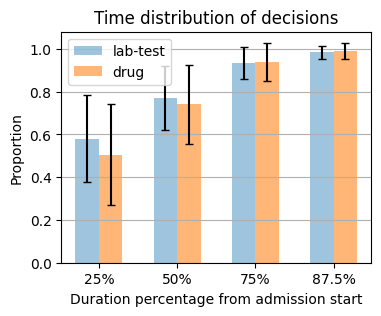

In [105]:
x_pos = np.arange(len(proportions))

fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(x_pos-0.15, labevent_proportions,     width=0.3, yerr=labevent_proportions_std,     align='center', alpha=0.43, ecolor='black', capsize=3)
ax.bar(x_pos+0.15, prescription_proportions, width=0.3, yerr=prescription_proportions_std, align='center', alpha=0.57, ecolor='black', capsize=3)

ax.set_ylabel('Proportion')
# ax.set_xlabel('Before x-axis of admission duration')
ax.set_xlabel('Duration percentage from admission start')

ax.set_xticks(x_pos)
ax.set_xticklabels(['25%', '50%', '75%', '87.5%'])

ax.legend(["lab-test", "drug"])

ax.set_title('Time distribution of decisions')
ax.yaxis.grid(True)

## other categorical variables

In [13]:
df_admissions.ADMISSION_TYPE.value_counts()

EMERGENCY    38465
ELECTIVE      6802
NEWBORN       3534
URGENT         690
Name: ADMISSION_TYPE, dtype: int64

In [14]:
df_admissions.ADMISSION_LOCATION.value_counts()

EMERGENCY ROOM ADMIT         20229
CLINIC REFERRAL/PREMATURE    11134
PHYS REFERRAL/NORMAL DELI    10209
TRANSFER FROM HOSP/EXTRAM     7507
TRANSFER FROM SKILLED NUR      221
** INFO NOT AVAILABLE **        96
TRANSFER FROM OTHER HEALT       53
HMO REFERRAL/SICK               37
TRSF WITHIN THIS FACILITY        5
Name: ADMISSION_LOCATION, dtype: int64

In [15]:
df_admissions.DISCHARGE_LOCATION.value_counts()

HOME                         13440
HOME HEALTH CARE             12959
SNF                           7370
REHAB/DISTINCT PART HOSP      5728
DEAD/EXPIRED                  5002
LONG TERM CARE HOSPITAL       2291
SHORT TERM HOSPITAL           1089
DISCH-TRAN TO PSYCH HOSP       440
HOSPICE-HOME                   388
LEFT AGAINST MEDICAL ADVI      311
DISC-TRAN CANCER/CHLDRN H      152
HOSPICE-MEDICAL FACILITY       148
OTHER FACILITY                  59
HOME WITH HOME IV PROVIDR       57
ICF                             45
DISC-TRAN TO FEDERAL HC         11
SNF-MEDICAID ONLY CERTIF         1
Name: DISCHARGE_LOCATION, dtype: int64

In [16]:
df_admissions.INSURANCE.value_counts()

Medicare      25569
Private       17260
Medicaid       4727
Government     1443
Self Pay        492
Name: INSURANCE, dtype: int64

In [17]:
df_admissions.LANGUAGE.value_counts()

ENGL    28360
SPAN      997
RUSS      715
PTUN      597
CANT      378
        ...  
*TAM        1
*PHI        1
*LEB        1
*PER        1
*ARA        1
Name: LANGUAGE, Length: 73, dtype: int64

In [18]:
df_admissions.RELIGION.value_counts()

CATHOLIC                  17579
NOT SPECIFIED             10522
PROTESTANT QUAKER          6218
UNOBTAINABLE               6176
JEWISH                     4487
OTHER                      2222
EPISCOPALIAN                652
GREEK ORTHODOX              405
CHRISTIAN SCIENTIST         339
BUDDHIST                    218
MUSLIM                      175
JEHOVAH'S WITNESS           122
UNITARIAN-UNIVERSALIST      112
HINDU                        87
ROMANIAN EAST. ORTH          70
7TH DAY ADVENTIST            65
HEBREW                        1
BAPTIST                       1
Name: RELIGION, dtype: int64

In [19]:
df_admissions.MARITAL_STATUS.value_counts()

MARRIED              21807
SINGLE               12013
WIDOWED               6571
DIVORCED              2932
SEPARATED              522
UNKNOWN (DEFAULT)      267
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

In [22]:
df_admissions.ETHNICITY.value_counts()

WHITE                                                       35277
BLACK/AFRICAN AMERICAN                                       4587
UNKNOWN/NOT SPECIFIED                                        3027
HISPANIC OR LATINO                                           1392
OTHER                                                        1203
ASIAN                                                         968
UNABLE TO OBTAIN                                              783
PATIENT DECLINED TO ANSWER                                    478
ASIAN - CHINESE                                               245
HISPANIC/LATINO - PUERTO RICAN                                223
BLACK/CAPE VERDEAN                                            185
WHITE - RUSSIAN                                               160
MULTI RACE ETHNICITY                                          105
BLACK/HAITIAN                                                  96
ASIAN - ASIAN INDIAN                                           81
WHITE - OT

---

# DIAGNOSES_ICD

In [6]:
df_diagnoses_icd = pd.read_csv(os.path.join(path_dataset, "DIAGNOSES_ICD.csv.gz"))
df_diagnoses_icd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ROW_ID      651047 non-null  int64  
 1   SUBJECT_ID  651047 non-null  int64  
 2   HADM_ID     651047 non-null  int64  
 3   SEQ_NUM     651000 non-null  float64
 4   ICD9_CODE   651000 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


In [7]:
df_diagnoses_icd.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [8]:
query_hadm_id = 172335
df_diagnoses_icd[df_diagnoses_icd.HADM_ID == query_hadm_id]

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254
5,1302,109,172335,6.0,2762
6,1303,109,172335,7.0,7100
7,1304,109,172335,8.0,2767
8,1305,109,172335,9.0,7243
9,1306,109,172335,10.0,45829


In [13]:
df_diagnoses_icd.ICD9_CODE.value_counts()

4019     20703
4280     13111
42731    12891
41401    12429
5849      9119
         ...  
V8709        1
5931         1
63310        1
0849         1
81504        1
Name: ICD9_CODE, Length: 6984, dtype: int64

## icd-9 entry number per hadm_id

mean: 11.03918543136191 
 std: 6.466180243627583


<AxesSubplot:title={'center':'ICD-9 entry number per hadm_id'}, ylabel='Frequency'>

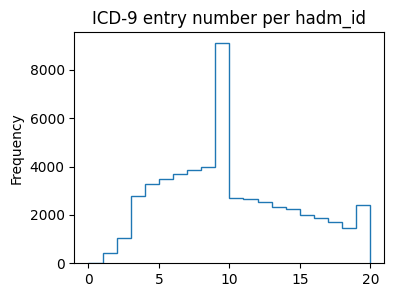

In [15]:
ser_icd9_entry_number_per_hadm_id = df_diagnoses_icd.groupby('HADM_ID').apply(lambda x: x.shape[0])
print(f"mean: {ser_icd9_entry_number_per_hadm_id.mean()}", "\n", f"std: {ser_icd9_entry_number_per_hadm_id.std()}")
ser_icd9_entry_number_per_hadm_id.plot(
    kind='hist', bins=20, range=(0, 20), histtype="step", figsize=(4, 3), title="ICD-9 entry number per hadm_id")

---
# D_LABITEMS

In [14]:
df_d_labitems = pd.read_csv(os.path.join(path_dataset, "D_LABITEMS.csv.gz"))
df_d_labitems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ROW_ID      753 non-null    int64 
 1   ITEMID      753 non-null    int64 
 2   LABEL       753 non-null    object
 3   FLUID       753 non-null    object
 4   CATEGORY    753 non-null    object
 5   LOINC_CODE  585 non-null    object
dtypes: int64(2), object(4)
memory usage: 35.4+ KB


In [7]:
df_d_labitems.head()

,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
0,546,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,26447-3
1,547,51347,Eosinophils,Cerebrospinal Fluid (CSF),Hematology,26451-5
2,548,51348,"Hematocrit, CSF",Cerebrospinal Fluid (CSF),Hematology,30398-2
3,549,51349,Hypersegmented Neutrophils,Cerebrospinal Fluid (CSF),Hematology,26506-6
4,550,51350,Immunophenotyping,Cerebrospinal Fluid (CSF),Hematology,NaN


In [16]:
df_d_labitems.FLUID.value_counts()

Blood                        359
Urine                        103
Other Body Fluid              82
Bone Marrow                   40
Ascites                       37
Pleural                       35
Cerebrospinal Fluid (CSF)     30
Joint Fluid                   26
BLOOD                         15
OTHER BODY FLUID               9
Stool                          6
URINE                          6
JOINT FLUID                    2
ASCITES                        1
STOOL                          1
CSF                            1
Name: FLUID, dtype: int64

In [9]:
df_d_labitems.CATEGORY.value_counts()

Hematology    410
Chemistry     274
Blood Gas      34
CHEMISTRY      19
HEMATOLOGY     13
BLOOD GAS       3
Name: CATEGORY, dtype: int64

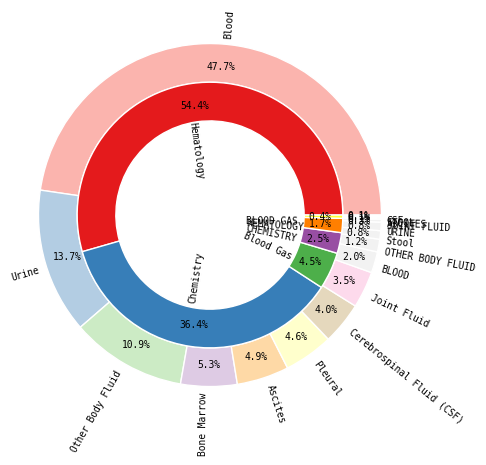

In [157]:
fig, ax = plt.subplots()

size = 0.3
radius = 1.33

outer_cmap = plt.colormaps["Pastel1"]
outer_colors = outer_cmap(np.arange(len(df_d_labitems.FLUID.value_counts())))
inner_cmap = plt.colormaps["Set1"]
inner_colors = inner_cmap(np.arange(len(df_d_labitems.CATEGORY.value_counts())))

ax.pie(df_d_labitems.FLUID.value_counts().values, 
       labels=df_d_labitems.FLUID.value_counts().index, labeldistance=1.03, rotatelabels=True, 
       radius=radius, colors=outer_colors, wedgeprops=dict(width=size, edgecolor='w'), 
       autopct="%1.1f%%", pctdistance=0.87, 
       textprops=dict(fontfamily="monospace", fontsize="x-small"))

ax.pie(df_d_labitems.CATEGORY.value_counts().values, 
       labels=df_d_labitems.CATEGORY.value_counts().index, labeldistance=0.27, rotatelabels=True, 
       radius=radius-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'), 
       autopct="%1.1f%%", pctdistance=0.83, 
       textprops=dict(fontfamily="monospace", fontsize="x-small"))

# ax.set(aspect="equal", title='Pie plot with `ax.pie`')

plt.tight_layout()
plt.show()
fig.savefig("/data/data2/041/LERS/results/item_categories")

---
# LABEVENTS

In [8]:
df_labevents = pd.read_csv(os.path.join(path_dataset, "LABEVENTS_PREPROCESSED.csv.gz"))

mask = df_labevents.HADM_ID.isin(list_total_hadmid)
df_labevents = df_labevents.loc[mask]

df_labevents.dropna(subset=['HADM_ID', 'ITEMID'], inplace=True)
df_labevents.sort_values(by=["HADM_ID", "ITEMID"], inplace=True)
df_labevents["CHARTTIME"] = pd.to_datetime(df_labevents["CHARTTIME"], format="%Y-%m-%d %H:%M:%S")  # Convert columns to datetime
df_labevents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13901838 entries, 0 to 15186985
Data columns (total 13 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Unnamed: 0         int64         
 1   ROW_ID             int64         
 2   SUBJECT_ID         int64         
 3   HADM_ID            float64       
 4   ITEMID             int64         
 5   CHARTTIME          datetime64[ns]
 6   VALUE              object        
 7   VALUENUM           float64       
 8   VALUEUOM           object        
 9   FLAG               object        
 10  CATAGORY           float64       
 11  VALUENUM_Z-SCORED  float64       
 12  TIMESTEP           float64       
dtypes: datetime64[ns](1), float64(5), int64(4), object(3)
memory usage: 1.5+ GB


In [10]:
df_labevents.head()

,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED,TIMESTEP
0,0,22441088,58526,100001.0,50813,2117-09-11 08:32:00,1.9,1.9,mmol/L,NaN,0.0,1.514175,0.0
1,1,22441061,58526,100001.0,50861,2117-09-11 08:22:00,10,10.0,IU/L,NaN,0.0,-1.200442,0.0
2,2,22441062,58526,100001.0,50863,2117-09-11 08:22:00,105,105.0,IU/L,NaN,0.0,1.276112,0.0
3,3,22441320,58526,100001.0,50868,2117-09-17 05:45:00,14,14.0,mEq/L,NaN,0.0,0.225221,6.0
4,8,22441141,58526,100001.0,50868,2117-09-11 23:17:00,16,16.0,mEq/L,NaN,0.0,0.931794,0.0


## Item frequency distribution

In [11]:
ser_items_count = df_labevents.ITEMID.value_counts() / len(df_labevents)
ser_items_count

50971    3.222516e-02
51221    3.214294e-02
50902    3.203281e-02
50983    3.190283e-02
50882    3.189024e-02
             ...     
51055    7.193293e-08
51330    7.193293e-08
51126    7.193293e-08
51242    7.193293e-08
51508    7.193293e-08
Name: ITEMID, Length: 702, dtype: float64

In [12]:
df_items_count = pd.DataFrame({
    "ITEMID": ser_items_count.index,
    "PERCENTAGE": ser_items_count.values
})
df_items_count

,ITEMID,PERCENTAGE
0,50971,3.222516e-02
1,51221,3.214294e-02
2,50902,3.203281e-02
3,50983,3.190283e-02
4,50882,3.189024e-02
...,...,...
697,51055,7.193293e-08
698,51330,7.193293e-08
699,51126,7.193293e-08
700,51242,7.193293e-08


In [15]:
df_items_count_with_label = df_items_count.merge(df_d_labitems[["ITEMID", "LABEL"]], how='left', on='ITEMID')
df_items_count_with_label

,ITEMID,PERCENTAGE,LABEL
0,50971,3.222516e-02,Potassium
1,51221,3.214294e-02,Hematocrit
2,50902,3.203281e-02,Chloride
3,50983,3.190283e-02,Sodium
4,50882,3.189024e-02,Bicarbonate
...,...,...,...
697,51055,7.193293e-08,"Lipase, Pleural"
698,51330,7.193293e-08,CD59
699,51126,7.193293e-08,Promyelocytes
700,51242,7.193293e-08,LUC


In [16]:
df_items_count_with_label_top50 = df_items_count_with_label[:50]
df_items_count_with_label_top50

,ITEMID,PERCENTAGE,LABEL
0,50971,0.032225,Potassium
1,51221,0.032143,Hematocrit
2,50902,0.032033,Chloride
3,50983,0.031903,Sodium
4,50882,0.031890,Bicarbonate
5,50912,0.031740,Creatinine
6,51006,0.031713,Urea Nitrogen
7,51265,0.031526,Platelet Count
8,50868,0.031472,Anion Gap
9,51301,0.031430,White Blood Cells


In [17]:
df_items_count_with_label_top50.PERCENTAGE.sum()

0.8624215013870828

In [18]:
1 - df_items_count_with_label_top50.PERCENTAGE.sum()

0.13757849861291715

In [19]:
df_items_count_with_label_top50.loc[len(df_items_count_with_label_top50)] = ['00000', 1 - df_items_count_with_label_top50.PERCENTAGE.sum(), 'Outsides top50']
df_items_count_with_label_top50

/data/data2/041/envs/LERS2/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


,ITEMID,PERCENTAGE,LABEL
0,50971,0.032225,Potassium
1,51221,0.032143,Hematocrit
2,50902,0.032033,Chloride
3,50983,0.031903,Sodium
4,50882,0.031890,Bicarbonate
5,50912,0.031740,Creatinine
6,51006,0.031713,Urea Nitrogen
7,51265,0.031526,Platelet Count
8,50868,0.031472,Anion Gap
9,51301,0.031430,White Blood Cells


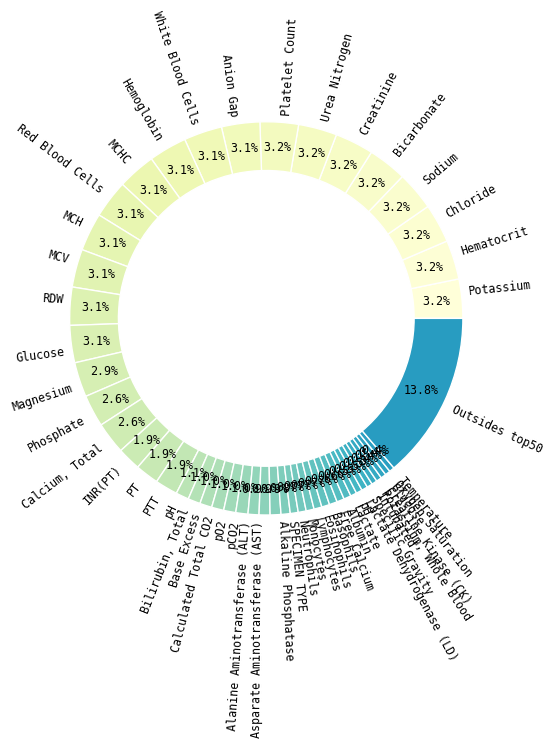

In [20]:
fig, ax = plt.subplots()

size = 0.33
radius = 1.33

cmap = plt.colormaps["YlGnBu"]
colors = cmap(np.arange(len(df_items_count_with_label_top50))*3)

ax.pie(df_items_count_with_label_top50.PERCENTAGE.values, 
       labels=df_items_count_with_label_top50.LABEL.values, labeldistance=1.03, rotatelabels=True, 
       radius=radius, colors=colors, wedgeprops=dict(width=size, edgecolor='w'), 
       autopct="%1.1f%%", pctdistance=0.87, 
       textprops=dict(fontfamily="monospace", fontsize="small"))

plt.show()
fig.savefig("/data/data2/041/LERS/results/top50_items")

## Map of top50

In [21]:
unique_item_id = df_d_labitems.ITEMID.sort_values().unique()
unique_item_id = pd.DataFrame(data={
    'ITEMID': unique_item_id,
    'mappedID': pd.RangeIndex(len(unique_item_id)),
})
unique_item_id

,ITEMID,mappedID
0,50800,0
1,50801,1
2,50802,2
3,50803,3
4,50804,4
...,...,...
748,51551,748
749,51552,749
750,51553,750
751,51554,751


In [48]:
unique_item_id[unique_item_id.ITEMID.isin(df_items_count_with_label_top50.ITEMID)]

,ITEMID,mappedID
0,50800,0
2,50802,2
4,50804,4
8,50808,8
9,50809,9
12,50812,12
13,50813,13
17,50817,17
18,50818,18
20,50820,20


In [22]:
unique_item_id[unique_item_id.ITEMID.isin(df_items_count_with_label_top50.ITEMID)].mappedID.values

array([  0,   2,   4,   8,   9,  12,  13,  17,  18,  20,  21,  22,  25,
        61,  62,  63,  68,  78,  82,  85,  93, 102, 110, 112, 131, 154,
       160, 170, 171, 183, 205, 345, 399, 420, 421, 436, 443, 447, 448,
       449, 453, 455, 464, 473, 474, 476, 478, 500, 690, 697])

## cnt_tests_by_day_per_hadmid

In [23]:
gb_hadmid_df_labevents = df_labevents.groupby("HADM_ID")

HADM_ID = 100001
gb_hadmid_df_labevents.get_group(HADM_ID).sort_values(by="TIMESTEP")

,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED,TIMESTEP
0,0,22441088,58526,100001.0,50813,2117-09-11 08:32:00,1.9,1.9,mmol/L,NaN,0.0,1.514175,0.0
48,90,22441147,58526,100001.0,50960,2117-09-11 23:17:00,1.9,1.9,mg/dL,NaN,0.0,-0.529679,0.0
54,101,22441148,58526,100001.0,50970,2117-09-11 23:17:00,2.5,2.5,mg/dL,abnormal,0.0,-1.956500,0.0
61,115,22441149,58526,100001.0,50971,2117-09-11 23:17:00,4.1,4.1,mEq/L,NaN,0.0,0.037039,0.0
68,129,22441150,58526,100001.0,50983,2117-09-11 23:17:00,144,144.0,mEq/L,NaN,0.0,1.610453,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,72,22441324,58526,100001.0,50931,2117-09-17 05:45:00,118,118.0,mg/dL,abnormal,0.0,2.999601,6.0
76,140,22441328,58526,100001.0,51006,2117-09-17 05:45:00,20,20.0,mg/dL,NaN,0.0,1.611212,6.0
60,110,22441326,58526,100001.0,50971,2117-09-17 05:45:00,3.7,3.7,mEq/L,NaN,0.0,-0.889575,6.0
47,87,22441325,58526,100001.0,50960,2117-09-17 05:45:00,1.9,1.9,mg/dL,NaN,0.0,-0.529679,6.0


In [24]:
bucket_elements_tests = []
for hadm_id, df_grouped_by_hadmid in tqdm(gb_hadmid_df_labevents):
    gb_timestep = df_grouped_by_hadmid.groupby("TIMESTEP")
    list_count = [df.shape[0] for _, df in gb_timestep]
    for idx, cnt in enumerate(list_count):
        bucket_elements_tests.append(cnt) if idx == len(bucket_elements_tests) else None
        bucket_elements_tests[idx] += cnt
        
num_hadm = df_labevents.HADM_ID.unique().shape[0]
bucket_elements_tests = [elm / num_hadm for elm in bucket_elements_tests]
df_cnt_tests_by_day_per_hadmid = pd.DataFrame(bucket_elements_tests, columns=["cnt_tests_by_day_per_hadmid"]).reset_index()
df_cnt_tests_by_day_per_hadmid

  0%|          | 0/49491 [00:00<?, ?it/s]

,index,cnt_tests_by_day_per_hadmid
0,0,41.046150
1,1,30.289467
2,2,25.261563
3,3,21.776222
4,4,18.744600
...,...,...
287,287,0.001334
288,288,0.001334
289,289,0.001172
290,290,0.001253


## statistics

In [43]:
list_hadm_id_P_T = []
list_cnt_relationships_P_T = []
for hadm_id, df_grouped_by_hadmid in tqdm(gb_hadmid_df_labevents):
    list_hadm_id_P_T.append(hadm_id)
    list_cnt_relationships_P_T.append(df_grouped_by_hadmid.shape[0])

pd_cnt_relationships_P_T = pd.DataFrame()
pd_cnt_relationships_P_T["HADM_ID"] = list_hadm_id_P_T
pd_cnt_relationships_P_T["cnt"] = list_cnt_relationships_P_T
pd_cnt_relationships_P_T.describe()

  0%|          | 0/49491 [00:00<?, ?it/s]

,HADM_ID,cnt
count,49491.000000,49491.000000
mean,150018.333333,280.896284
std,28901.701105,323.204757
min,100001.000000,1.000000
25%,124955.500000,111.000000
50%,150073.000000,184.000000
75%,175062.500000,323.000000
max,199999.000000,9403.000000


---

# PRESCRIPTIONS

In [7]:
df_prescriptions = pd.read_csv(os.path.join(path_dataset, "PRESCRIPTIONS_PREPROCESSED.csv.gz"))
mask = df_prescriptions.HADM_ID.isin(list_total_hadmid)
df_prescriptions = df_prescriptions.loc[mask]
df_prescriptions.head()

/data/data2/041/envs/LERS2/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3269: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,...,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE,TIMESTEP
0,0,102562,492937,3951837,89132,198797,NaN,2151-06-27,2151-06-28,1,...,CYAN500,2341.0,8.770107e+10,1,1.0,11.0,1,1.0,3,0.0
1,1,245100,492946,3951840,89132,198797,NaN,2151-06-27,2151-06-28,1,...,CARA1,2766.0,6.373903e+10,1,1.0,4.0,1,1.0,3,0.0
2,2,1671716,11792392,3951836,89132,198797,NaN,2151-06-27,2151-06-28,1,...,ATEN25,15864.0,5.107908e+10,1,2.0,1.0,2,1.0,3,0.0
3,3,1835301,11792393,3951835,89132,198797,NaN,2151-06-27,2151-06-28,1,...,ALLO100,2535.0,5.107902e+10,1,1.0,1.0,1,1.0,3,0.0
4,4,2083587,492934,3951834,89132,198797,NaN,2151-06-27,2151-06-28,1,...,PRAV20,16367.0,5.107905e+10,1,1.0,1.0,1,1.0,2,0.0


In [9]:
gb_hadmid_df_prescriptions = df_prescriptions.groupby("HADM_ID")

HADM_ID = 100001
gb_hadmid_df_prescriptions.get_group(HADM_ID).sort_values(by="TIMESTEP")

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,...,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE,TIMESTEP
9979995,11584236,538477,414991,3965945,58526,100001,275225.0,2117-09-11,2117-09-12,1,...,HEPA5I,6549.0,6.332303e+10,1,1.0,3.0,1,2.0,4,0.0
9980008,11584249,10076279,414955,3965937,58526,100001,275225.0,2117-09-11,2117-09-12,1,...,NACLFLUSH,NaN,1.000000e+00,1,1.0,2.0,1,5.0,1,0.0
9980006,11584247,9852852,416267,3966692,58526,100001,275225.0,2117-09-11,2117-09-12,1,...,INHRIV,1723.0,2.821501e+06,3,1.0,3.0,1,2.0,5,0.0
9980005,11584246,7794560,414961,3965938,58526,100001,275225.0,2117-09-11,2117-09-12,1,...,OMEP20,33530.0,9.352119e+07,1,1.0,1.0,1,6.0,2,0.0
9980004,11584245,7588657,414997,3965946,58526,100001,275225.0,2117-09-11,2117-09-12,1,...,MAAL30L,2701.0,1.211761e+08,1,1.0,2.0,1,7.0,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980099,11584362,1042242,414972,3965939,58526,100001,275225.0,2117-09-16,2117-09-17,1,...,CITA20,46203.0,6.050525e+10,1,1.0,1.0,1,1.0,3,5.0
9980098,11584361,538482,414996,3965945,58526,100001,275225.0,2117-09-16,2117-09-17,1,...,HEPA5I,6549.0,6.332303e+10,1,1.0,3.0,1,2.0,4,5.0
9980112,11584378,10076324,416301,3966722,58526,100001,275225.0,2117-09-16,2117-09-17,1,...,NACLFLUSH,NaN,1.000000e+00,1,1.0,2.0,1,5.0,1,5.0
9980104,11584368,4987702,416291,3966704,58526,100001,275225.0,2117-09-16,2117-09-17,1,...,LORA2I,3753.0,4.091985e+08,1,3.0,1.0,3,2.0,1,5.0


## statistics

In [42]:
list_hadm_id_P_D = []
list_cnt_relationships_P_D = []
for hadm_id, df_grouped_by_hadmid in tqdm(gb_hadmid_df_prescriptions):
    list_hadm_id_P_D.append(hadm_id)
    list_cnt_relationships_P_D.append(df_grouped_by_hadmid.shape[0])

pd_cnt_relationships_P_D = pd.DataFrame()
pd_cnt_relationships_P_D["HADM_ID"] = list_hadm_id_P_D
pd_cnt_relationships_P_D["cnt"] = list_cnt_relationships_P_D
pd_cnt_relationships_P_D.describe()

  0%|          | 0/49491 [00:00<?, ?it/s]

,HADM_ID,cnt
count,49491.000000,49491.000000
mean,150018.333333,205.750702
std,28901.701105,307.014583
min,100001.000000,1.000000
25%,124955.500000,52.000000
50%,150073.000000,118.000000
75%,175062.500000,236.000000
max,199999.000000,11705.000000


## cnt_drugs_by_day_per_hadmid

In [25]:
bucket_elements_drugs = []
for hadm_id, df_grouped_by_hadmid in tqdm(gb_hadmid_df_prescriptions):
    gb_timestep = df_grouped_by_hadmid.groupby("TIMESTEP")
    list_count = [df.shape[0] for _, df in gb_timestep]
    for idx, cnt in enumerate(list_count):
        bucket_elements_drugs.append(cnt) if idx == len(bucket_elements_drugs) else None
        bucket_elements_drugs[idx] += cnt
        
num_hadm = df_prescriptions.HADM_ID.unique().shape[0]
bucket_elements_drugs = [elm / num_hadm for elm in bucket_elements_drugs]
df_cnt_drugs_by_day_per_hadmid = pd.DataFrame(bucket_elements_drugs, columns=["cnt_drugs_by_day_per_hadmid"]).reset_index()
df_cnt_drugs_by_day_per_hadmid

  0%|          | 0/49491 [00:00<?, ?it/s]

,index,cnt_drugs_by_day_per_hadmid
0,0,15.293508
1,1,17.109050
2,2,16.262371
3,3,15.073084
4,4,13.600917
...,...,...
289,289,0.001374
290,290,0.001293
291,291,0.001293
292,292,0.001293


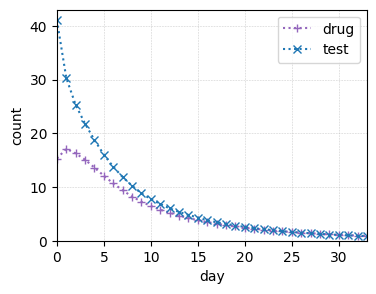

In [35]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(df_cnt_drugs_by_day_per_hadmid.index, df_cnt_drugs_by_day_per_hadmid.cnt_drugs_by_day_per_hadmid, '+C4:')
ax.plot(df_cnt_tests_by_day_per_hadmid.index, df_cnt_tests_by_day_per_hadmid.cnt_tests_by_day_per_hadmid, 'xC0:')
ax.set_ylabel("count")
ax.set_xlabel("day")
ax.set_xlim(0, 33)
ax.set_ylim(0, 43)
ax.grid(True, linestyle=':', linewidth=.43)
ax.legend(["drug", "test"])

# Procedure

In [9]:
df_procedures = pd.read_csv(os.path.join(path_dataset, "PROCEDURES_ICD.csv.gz"), dtype={'ICD9_CODE':'category'})
df_procedures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240095 entries, 0 to 240094
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   ROW_ID      240095 non-null  int64   
 1   SUBJECT_ID  240095 non-null  int64   
 2   HADM_ID     240095 non-null  int64   
 3   SEQ_NUM     240095 non-null  int64   
 4   ICD9_CODE   240095 non-null  category
dtypes: category(1), int64(4)
memory usage: 7.9 MB


In [10]:
df_procedures.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,944,62641,154460,3,3404
1,945,2592,130856,1,9671
2,946,2592,130856,2,3893
3,947,55357,119355,1,9672
4,948,55357,119355,2,0331


In [11]:
query_hadm_id = 119355
df_procedures[df_procedures.HADM_ID == query_hadm_id]

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
3,947,55357,119355,1,9672
4,948,55357,119355,2,0331
5,949,55357,119355,3,3893
